# CSC2515 Final Project
## Stock Market Trend Prediction by News Headlinesand LSTM
Yuzhou Liu, Department of Statistical Science, University of Toronto
<br>Yingying Zhou, Faculty of Information, University of Toronto</br>

### Import packages

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization, GRU, Dropout
from keras import metrics, optimizers

### Generate technical indicators

In [6]:
def get_techinical_indicators(data):
    # 7 and 21 days moving average
    data['ma7'] = data['Close'].rolling(window=7, min_periods=1).mean()
    data['ma21'] = data['Close'].rolling(window=21, min_periods=1).mean()

    # Exponential moving average
    data['ema'] = data['Close'].ewm(com=0.5).mean()

    return data

### Load data & Feature engineering

In [7]:
def get_data():
    stock_data = pd.read_csv('upload_DJIA_table.csv', index_col = 'Date')
    news_data = pd.read_csv('combined_stock_data.csv', index_col='Date')

    # Filter the dates where the headlines are incompletet
    missing_dates = [i for i, r in news_data.iterrows() if not isinstance(r['Para'], str)]

    news_data = news_data[~news_data.index.isin(missing_dates)]
    stock_data = stock_data[~stock_data.index.isin(missing_dates)]

    # Store the Length for all headlines in 'ParaLength'
    news_data['Para'] = news_data['Para'].str.replace('b', '')
    news_data = news_data.assign( ParaLength = news_data['Para'].apply(lambda x: len(x.split())) )

    # Merge the news data with the stock data
    merged_news = news_data[['Label', 'Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 
                             'Para']].merge(stock_data, how='inner', left_index=True, right_index=True)
    merged_news.sort_index()
    
    # Compute techinical indicators
    megred_news = get_techinical_indicators(merged_news)

    # Put columns 'Label' and 'Para' to the end of df
    cols = list(merged_news)
    cols.append(cols.pop(cols.index('Label')))
    cols.append(cols.pop(cols.index('Para')))
    merged_news = merged_news.loc[:, cols]

    merged_news = merged_news.dropna()

    return stock_data, news_data, merged_news

In [8]:
stock_data, news_data, merged_news = get_data()

In [9]:
merged_news.head(3)

,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,ma7,ma21,ema,Label,Para
Date,,,,,,,,,,,,,,,,
2008-08-08,75.000000,25.000000,18.750000,56.250000,25.000000,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,11734.320312,11734.320312,11734.320312,0,"""Georgia 'downs two Russian warplanes' as coun..."
2008-08-11,83.333333,16.666667,41.666667,41.666667,16.666667,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,11758.334961,11758.334961,11770.342285,1,'Why wont America and Nato help us? If they wo...
2008-08-12,56.250000,43.750000,18.750000,37.500000,43.750000,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,11719.713216,11719.713216,11681.815129,0,'Rememer that adorale 9-year-old who sang at t...


## EDA

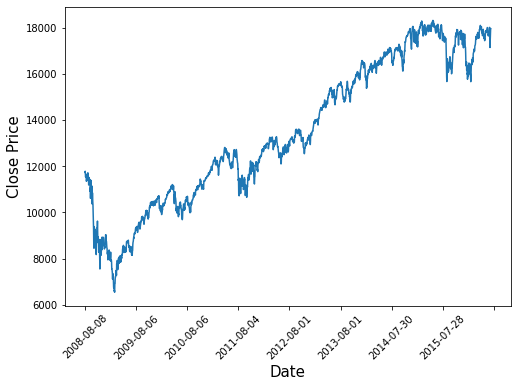

In [12]:
# Plot the close price and volum //TODO
plt.figure(figsize=(8,5.5))
merged_news['Adj Close'].plot()
plt.xticks(rotation=45)
plt.ylabel('Close Price',fontsize=15)
plt.xlabel('Date',fontsize=15)
plt.show()

In [ ]:
# The distribution of labels
merged_news['Label'].value_counts(normalize=True)

1    0.534743
0    0.465257
Name: Label, dtype: float64

### Distribution of sentiment scores by their class

In [13]:
# statistical summary of sentiments
merged_news.describe()

,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,ma7,ma21,ema,Label
count,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000,1.986000e+03,1986.000000,1986.000000,1986.000000,1986.000000,1986.000000
mean,56.712522,43.287478,19.966718,36.745804,43.287478,13463.058741,13545.271995,13376.772929,13466.899126,1.628337e+08,13466.899126,13457.838903,13436.328130,13465.345328,0.534743
std,21.557927,21.557927,16.373424,21.109970,21.557927,3143.678855,3136.644307,3150.903434,3144.468618,9.395177e+07,3144.468618,3137.538141,3123.519544,3142.641995,0.498917
min,0.000000,0.000000,0.000000,0.000000,0.000000,6547.009766,6709.609863,6469.950195,6547.049805,8.410000e+06,6547.049805,6722.867118,7071.915713,6579.275502,0.000000
25%,40.000000,28.571429,8.333333,21.859903,28.571429,10913.674805,11022.854736,10825.817383,10919.824707,1.000375e+08,10919.824707,10956.851109,10958.817987,10926.594820,0.000000
50%,54.545455,45.454545,18.181818,33.333333,45.454545,13026.960450,13090.750000,12960.669922,13031.004883,1.351250e+08,13031.004883,13027.652693,13018.168759,13029.452509,1.000000
75%,71.428571,60.000000,28.571429,50.000000,60.000000,16482.244629,16554.959961,16396.288086,16479.513183,1.925525e+08,16479.513183,16473.057059,16479.965367,16480.304978,1.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,18315.060547,18351.359375,18272.560547,18312.390625,6.749200e+08,18312.390625,18277.033203,18120.696708,18301.922055,1.000000


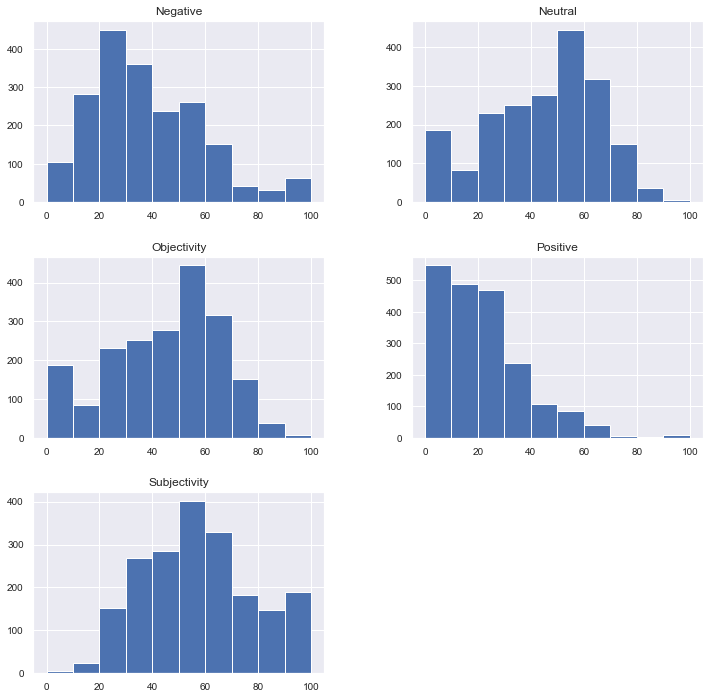

In [14]:
import seaborn as sns
sns.set()
merged_news[['Subjectivity','Objectivity','Positive','Negative','Neutral']].hist(\
                    sharex = False, sharey = False, xlabelsize = 10, ylabelsize = 10, figsize=(12, 12))
plt.show()

## Train Test Split

In [ ]:
X = merged_news.loc[:,'Subjectivity':'ema']
y = merged_news.loc[:,'Label']

In [ ]:
X_all = merged_news.copy(deep=True)
X_all['RowNum'] = range(len(X_all))

In [ ]:
X_train = merged_news.loc[:'2014-12-31',:]
X_test = merged_news.loc['2015-01-01':,:]

Y_train = X_train.loc[:,'Label']
Y_test = X_test.loc[:,'Label']

In [ ]:
# split into training/valuation set
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2)

In [ ]:
# lagged features list
feature_lag = ['Subjectivity','Objectivity','Positive','Negative','Neutral','High','Low','Volume','Close','Adj Close','ma7','ma21','ema']

# Shift the features in the lagged feature list 
X_lag = merged_news.copy(deep=True)
X_lag.loc[:,feature_lag] = X_lag.shift(1).loc[:,feature_lag]
X_lag = X_lag.dropna()

# Split the data into train and test data
X_train_lag = X_lag.loc[:'2014-12-31',:]
X_test_lag = X_lag.loc['2015-01-01':,:]

Y_train_lag = X_train_lag.loc[:,'Label']
Y_test_lag = X_test_lag.loc[:,'Label']

# split the lagged data into training/valuation set
x_train_lag, x_val_lag, y_train_lag, y_val_lag = train_test_split(X_train_lag, Y_train_lag, test_size=0.2)

## XGBoost with PCA transformation:

In [ ]:
feature_list = ['Subjectivity','Objectivity','Positive','Negative','Neutral','Open','High','Low','Volume','Close','ma7','ema']

In [ ]:
# XGBoost & PCA with lagged data
pca = PCA(n_components=7)
pca.fit(X_train_lag.loc[:,feature_list])

# PCA transform training set
X_train_lag_trans = pca.transform(X_train_lag.loc[:,feature_list])
X_train_lag_pca = pd.DataFrame(X_train_lag_trans)
print(X_train_lag_pca.shape)

# PCA transform test set
X_test_lag_pca = pd.DataFrame(pca.transform(X_test_lag.loc[:,feature_list]))
print(X_test_lag_pca.shape)

(1607, 7)
(378, 7)


In [ ]:
# Feed the data into the Classifier
clf = XGBClassifier(n_estimators=25, max_depth=3)
clf.fit(X_train_lag_pca, Y_train_lag)

# Predict over training set
y_pred_train_lag_pca = clf.predict(X_train_lag_pca)
score_train = accuracy_score(y_pred_train_lag_pca, Y_train_lag)
print('Trainig set accuracy (with lag = 1): {:.2%}'.format(score_train))

# Predict over test set
y_pred_test_lag_pca = clf.predict(X_test_lag_pca)
score_test = accuracy_score(y_pred_test_lag_pca, Y_test_lag)
print('Test set accuracy (with lag = 1): {:.2%}'.format(score_test))

Trainig set accuracy (with lag = 1): 62.39%
Test set accuracy (with lag = 1): 56.08%


### Performance measure: ROC curve

AUC score is 0.5521393369175627
roc auc is :0.5521393369175627


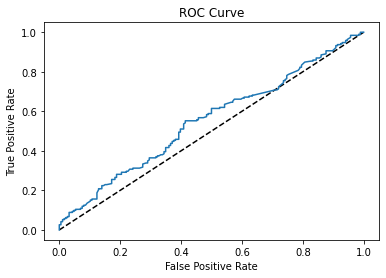

In [ ]:
# Generating the ROC curve
y_pred_proba_lag_pca = clf.predict_proba(X_test_lag_pca)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test_lag, y_pred_proba_lag_pca)
roc_auc = auc(fpr, tpr)
print("AUC score is " + str(roc_auc))

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [ ]:
class Net(nn.Module):
    def __init__(self, nNodes, nClasses, nDims):
        super(Net, self).__init__()
        
        self.f_in_to_h1 = nn.Linear(nDims, nNodes)
        self.f_h1_to_h2 = nn.Linear(nNodes, nNodes)
        self.f_h2_to_out = nn.Linear(nNodes, nClasses)

    def forward(self, x):
        relu = nn.ReLU()
        
        h1 = relu(self.f_in_to_h1(x))
        h2 = relu(self.f_h1_to_h2(h1))
        y = self.f_h2_to_out(h2)
        return y

In [ ]:
class StockData(Dataset):
    def __init__(self, df, complete_data, feature_list, lag):
        self.df = df.copy(deep=True)
        self.df.reset_index(inplace=True)
        self.complete_data = complete_data
        self.row_list = feature_list
        self.lag = lag
        self.lag_list = feature_list[:]
        self.lag_list.remove('Open')
        #self.df.reset_index(drop=True, inplace=True)
        
    def __len__(self):
        return(len(self.df))

    def __getitem__(self, index):
        today = self.df.loc[index, 'Date']
      
        if (self.lag==True):
            features = self.df.loc[index, self.row_list]
            RowNum = self.complete_data.loc[today, 'RowNum']
            
            if RowNum > 0:
                Yesterday = self.complete_data.index[RowNum-1]
                features[self.lag_list] = self.complete_data.loc[Yesterday, self.lag_list].values

        features_tensor = torch.tensor(features)
        
        labels = self.df.loc[index, 'Label']
        labels_tensor = torch.tensor(labels)
        
        #today_tensor = torch.tensor(list(today))

        return features_tensor, labels_tensor, today

In [ ]:
def train(net, train_loader, val_loader, feature_list, loss_func, opti, epochs, GPU=False):
    loss_hist = []
    val_loss_all = []
    val_acc_all = []
    
    for epoch in range(epochs):
        for _, (stockdata, labels, dates) in enumerate(train_loader):
            opti.zero_grad()
            if GPU==True:
                stockdata, labels, dates = stockdata.to(device), labels.to(device), dates 
           
            outputs = net(stockdata.float())
            
            loss = loss_func(outputs, labels)
            loss.backward()
            opti.step()
            loss_hist.append(loss.item())
            
        cnt, val_acc, val_loss = evaluate(net, loss_func, val_loader, GPU)
        
        if (epoch % (epochs/10)) == 0:
            print(" {} Validation Data, Validation Accuracy : {}, Validation Loss : {}".format(cnt, val_acc, val_loss))
            val_acc_all.append(val_acc)
            val_loss_all.append(val_loss)

In [ ]:
def evaluate(net, loss_func, dataloader, GPU=False):
    net.eval()
    acc, loss = 0, 0
    cnt = len(dataloader)
    
    with torch.no_grad():
        for stockdata, labels, dates in dataloader:
            if GPU==True:
                stockdata, labels, dates = stockdata.to(device), labels.to(device), dates
            outputs = net(stockdata.float())
            loss += loss_func(outputs, labels)
            
            predicted = outputs.max(dim = 1)[1]
            acc += (predicted == labels).float().mean()
            
            #if count > val_fraction * len(x_val):
                #break
                
    mean_acc = acc/cnt
    mean_loss = loss/cnt
                
    return cnt, mean_acc, mean_loss

In [ ]:
feature_list_nn = ['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'Open', 'High', 'Low', 'Volume', 'Close', 'Adj Close','ma7'] 
val_fraction = 0.05

In [ ]:
print('Length of x_train: '+str(len(x_train)))
x_train.head()

Length of x_train: 1286


,Subjectivity,Objectivity,Positive,Negative,Neutral,Open,High,Low,Close,Volume,Adj Close,Label,Para,ma7,ema
Date,,,,,,,,,,,,,,,
2010-04-23,58.333333,41.666667,25.000000,33.333333,41.666667,11132.179688,11205.639648,11105.650391,11204.280273,207380000,11204.280273,1,"'A Saudi law firm claiming to represent 94,000...",11119.404297,11179.153029
2010-10-25,40.000000,60.000000,0.000000,40.000000,60.000000,11133.400391,11247.599609,11132.339844,11164.049805,168110000,11164.049805,1,Afghanistan's President Karzai admits that his...,11105.177176,11152.662178
2013-11-27,61.538462,38.461538,15.384615,46.153846,38.461538,16073.370117,16107.990234,16057.339844,16097.330078,65730000,16097.330078,1,US flies B52 aircraft over disputed islands in...,16026.468610,16087.798217
2014-05-27,100.000000,0.000000,33.333333,66.666667,0.000000,16607.419922,16688.689453,16607.419922,16675.500000,80870000,16675.500000,1,"The Soma coal mine, where 301 workers lost the...",16533.627093,16643.618223
2010-07-21,66.666667,33.333333,33.333333,33.333333,33.333333,10226.019531,10265.540039,10065.500000,10120.530273,203900000,10120.530273,0,A Palestinian man has een convicted of rape af...,10241.695592,10149.697066


In [ ]:
train_ = StockData(x_train, X_all, feature_list_nn, lag=True)
val_ = StockData(x_val, X_all, feature_list_nn, lag=True)

In [ ]:
train_loader = DataLoader(train_, batch_size=8, num_workers=4, shuffle=True)
val_loader = DataLoader(val_, batch_size=1, num_workers = 4)

print('Train Batch Size: {}'.format(len(train_loader)))
print('Validation Batch Size: {}'.format(len(val_loader)))

Train Batch Size: 161
Validation Batch Size: 322


In [ ]:
nNodes = 50
nClasses = 2
nDim = len(feature_list_nn)

In [ ]:
net = Net(nNodes, nClasses, nDim)

In [ ]:
# Please ignore if you do not need it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Current Device: {} \n'.format(device))

net.to(device)

Current Device: cuda 



Net(
  (f_in_to_h1): Linear(in_features=12, out_features=50, bias=True)
  (f_h1_to_h2): Linear(in_features=50, out_features=50, bias=True)
  (f_h2_to_out): Linear(in_features=50, out_features=2, bias=True)
)

In [ ]:
loss_func = nn.CrossEntropyLoss()
opti = optim.Adam(net.parameters(), lr = 1e-3)
#m = nn.LogSoftmax(dim=1)

In [ ]:
torch.cuda.set_device(0)

In [ ]:
train(net, train_loader, val_loader, feature_list_nn, loss_func, opti, 100, GPU=True)

 322 Validation Data, Validation Accuracy : 0.5, Validation Loss : 119871.1328125
 322 Validation Data, Validation Accuracy : 0.5, Validation Loss : 88803.0625
 322 Validation Data, Validation Accuracy : 0.5, Validation Loss : 30642.47265625
 322 Validation Data, Validation Accuracy : 0.5, Validation Loss : 18897.603515625
 322 Validation Data, Validation Accuracy : 0.5, Validation Loss : 8240.5166015625
 322 Validation Data, Validation Accuracy : 0.5, Validation Loss : 2865.26171875
 322 Validation Data, Validation Accuracy : 0.5, Validation Loss : 79.97328186035156
 322 Validation Data, Validation Accuracy : 0.5124223828315735, Validation Loss : 10.899392127990723
 322 Validation Data, Validation Accuracy : 0.5124223828315735, Validation Loss : 2.6415698528289795
 322 Validation Data, Validation Accuracy : 0.5031055808067322, Validation Loss : 12.03015422821045


In [ ]:
X_test_lagged = X_test.copy(deep=True)
X_test_lagged.loc[:,['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral','High', 'Low','Volume','Close','Adj Close','ma7']] = X_test.shift(1).loc[:,['Subjectivity', 'Objectivity', 'Positive', 'Negative', 'Neutral', 'High', 'Low','Volume','Close','Adj Close','ma7']]
X_test_lagged = X_test_lagged.dropna().loc[:,feature_list_nn]
X_test_lagged_tensor = torch.tensor(X_test_lagged.values).float()
X_test_lagged_tensor = X_test_lagged_tensor.to(device)

In [ ]:
#X_test_tensor = torch.tensor(X_test.loc[:,feature_list].values).float()
#out = net(X_test_tensor)
out = net(X_test_lagged_tensor)
Y_test_pred = out.max(dim = 1)[1]
np.sum(Y_test_pred.tolist()==Y_test[1:].values)/len(Y_test)

0.5052910052910053

# RNN - LSTM

### Preprocessing the dataset
1. Split dataset into X and y
2. Prepare X to feed in RNN with sequential length of 60 (model1) and 90 (model2)

We are using cross entropy loss function and accuracy for metrics evaluation with adam optimizer for BINARY CLASSIFICATION

In [ ]:
feature_list = ['Label','Subjectivity','Objectivity','Positive','Negative','Neutral','Open','High','Low','Volume','Close','ma7']

In [ ]:
seq_len_lstm = 60

X_train_lstm = merged_news.loc[:'2014-12-31', feature_list].dropna()
X_test_lstm = merged_news.loc['2015-01-01':, feature_list]
Y_train_lstm = merged_news.loc[:'2014-12-31','Label']
Y_test_lstm = merged_news.loc['2015-01-01':,'Label']

X_train_lstm = np.array(X_train_lstm)
X_test_lstm = np.array(X_test_lstm.values)
Y_train_lstm = np.array(Y_train_lstm)
Y_test_lstm = np.array(Y_test_lstm)

#Normalize data
scaler1 = StandardScaler()
scaler1.fit(X_train_lstm)
X_train_lstm_trans = scaler1.transform(X_train_lstm)
X_test_lstm_trans = scaler1.transform(X_test_lstm)

# Build data lstm with lagged sequence = seq_len_lstm
x_train_lstm, y_train_lstm =([],[])

for i in range(seq_len_lstm, X_train_lstm_trans.shape[0]):
    x_train_lstm.append(X_train_lstm_trans[i-seq_len_lstm:i])
    y_train_lstm.append(Y_train_lstm[i])
    
x_train_lstm = np.array(x_train_lstm)
x_train_lstm = x_train_lstm.reshape((x_train_lstm.shape[0], x_train_lstm.shape[1], len(feature_list)))
y_train_lstm = np.array(y_train_lstm)
y_train_lstm = y_train_lstm.reshape((y_train_lstm.shape[0],1))
print(x_train_lstm.shape)

x_test_lstm, y_test_lstm=([],[])

for i in range(seq_len_lstm, X_test_lstm.shape[0]):
    x_test_lstm.append(X_test_lstm_trans[i-seq_len_lstm:i])
    y_test_lstm.append(Y_test_lstm[i])
    
#Transform the data into proper shape
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = x_test_lstm.reshape((x_test_lstm.shape[0],x_test_lstm.shape[1],len(feature_list)))
y_test_lstm = np.array(y_test_lstm)
y_test_lstm = y_test_lstm.reshape((y_test_lstm.shape[0],1))
print(x_test_lstm.shape)

(1548, 60, 12)
(318, 60, 12)


In [ ]:
# Model 1: LSTM
model1 = Sequential()
model1.add(LSTM(128, input_shape=(x_train_lstm.shape[1],x_train_lstm.shape[2]), return_sequences=True))
model1.add(BatchNormalization())
model1.add(LSTM(128))
model1.add(BatchNormalization())
model1.add(Dense(1, activation='sigmoid'))

In [ ]:
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
optimizers.Adam(learning_rate=1e-3)

In [ ]:
history1 = model1.fit(x_train_lstm, y_train_lstm, epochs=25, batch_size=64)

Epoch 1/25
25/25 [==============================] - 6s 226ms/step - loss: 0.7817 - accuracy: 0.5013
Epoch 2/25
25/25 [==============================] - 6s 226ms/step - loss: 0.7049 - accuracy: 0.5472
Epoch 3/25
25/25 [==============================] - 6s 230ms/step - loss: 0.7021 - accuracy: 0.5459
Epoch 4/25
25/25 [==============================] - 6s 229ms/step - loss: 0.6883 - accuracy: 0.5640
Epoch 5/25
25/25 [==============================] - 6s 227ms/step - loss: 0.6859 - accuracy: 0.5614
Epoch 6/25
25/25 [==============================] - 6s 228ms/step - loss: 0.6930 - accuracy: 0.5536
Epoch 7/25
25/25 [==============================] - 6s 235ms/step - loss: 0.6880 - accuracy: 0.5484
Epoch 8/25
25/25 [==============================] - 6s 221ms/step - loss: 0.6830 - accuracy: 0.5568
Epoch 9/25
25/25 [==============================] - 5s 217ms/step - loss: 0.6776 - accuracy: 0.5730
Epoch 10/25
25/25 [==============================] - 6s 225ms/step - loss: 0.6749 - accuracy: 0.5743

In [ ]:
# model evaluation
scores1 = model1.evaluate(x_test_lstm, y_test_lstm, verbose=0)
print("Accuracy with LSTM: %.2f%%" % (scores1[1]*100))

Accuracy with LSTM: 53.46%


# LSTM with ARIMA as a Feature

In [ ]:
!pip install pmdarima
from pmdarima import auto_arima

In [ ]:
seq_len_arima =180

In [ ]:
# Adding ARIMA to the training data using the space window = seq_len
def rolling_arima(df):
    model = auto_arima(df.values, error_action='ignore', suppress_warnings=True)
    model.fit(df.values)
    y_hat = model.predict(1)
    return y_hat

In [ ]:
# Lagged sequence length = 180
X_lag['rolling arima'] = X_lag['Close'].rolling(window=seq_len).apply(lambda x: rolling_arima(x))
X_lag.to_csv('X_lag_seqlen=180.csv', index=None)

In [ ]:
feature_list = ['Label','Subjectivity','Objectivity','Positive','Negative','Neutral','Open','High','Low','Volume','Close','ma7','rolling arima']

In [ ]:
X_train_arima = X_lag.loc[:'2014-12-31', feature_list].dropna()
X_test_arima = X_lag.loc['2015-01-01':, feature_list]

Y_train_arima = X_lag.loc[:'2014-12-31','Label']
Y_test_arima = X_lag.loc['2015-01-01':,'Label']

X_train_arima = np.array(X_train_arima)
X_test_arima = np.array(X_test_arima)
Y_train_arima = np.array(Y_train_arima)
Y_test_arima = np.array(Y_test_arima)

In [ ]:
# Scaler for data with arima
scaler2 = StandardScaler()
scaler2.fit(X_train_arima)
X_train_arima_trans = scaler2.transform(X_train_arima)

In [ ]:
x_train_arima,y_train_arima=([],[])

for i in range(seq_len_arima-1, X_train_arima.shape[0]):
    if i == (X_train_arima_trans.shape[0]-1):
        x_train_arima.append(X_train_arima_trans[i-seq_len+1:])
        y_train_arima.append(Y_train_arima[i])
        break
    x_train_arima.append(X_train_arima_trans[i-seq_len_arima+1:i+1])
    y_train_arima.append(Y_train_arima[i])
    
x_train_arima = np.array(x_train_arima)
x_train_arima = x_train_arima.reshape((x_train_arima.shape[0], x_train_arima.shape[1], len(feature_list)))
y_train_arima = np.array(y_train_arima)
y_train_arima = y_train_arima.reshape((y_train_arima.shape[0],1))

print(x_train_arima.shape)

(1249, 180, 13)


In [ ]:
x_test_arima,y_test_arima=([],[])
XX_lag = X_lag.loc[:,feature_list].values

for i in range(X_test.shape[0]):
    loc = XX_lag.shape[0] - X_test.shape[0] + i
    y_test_arima.append(Y_test_arima[i])

    if i == (X_test.shape[0]-1):
        x_test_arima.append(scaler2.transform(XX_lag[loc+1-seq_len_arima:])) 
        break

    x_test_arima.append(scaler2.transform(XX_lag[loc+1-seq_len_arima:loc+1]))

x_test_arima = np.array(x_test_arima)
x_test_arima = x_test_arima.reshape((x_test_arima.shape[0],x_test_arima.shape[1],len(feature_list)))
y_test_arima = np.array(y_test_arima)
y_test_arima = y_test.reshape((y_test_arima.shape[0],1))

print(x_test_arima.shape)

(378, 180, 13)


In [ ]:
# Model 2: LSTM with rolling ARIMA in features
model2 = Sequential()
model2.add(LSTM(128, input_shape=(x_train_arima.shape[1],x_train_arima.shape[2]), return_sequences=True))
model2.add(BatchNormalization())
model2.add(LSTM(128))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='sigmoid'))

In [ ]:
x_train_arima.shape

(1249, 180, 13)

In [ ]:
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=[metrics.RootMeanSquaredError(name='RMSE'), 'acc'])
optimizers.Adam(learning_rate=1e-5)

In [ ]:
history2 = model2.fit(x_train_arima, y_train_arima, epochs=50, batch_size=64)

Epoch 1/40
20/20 [==============================] - 13s 632ms/step - loss: 0.7732 - RMSE: 0.5283 - acc: 0.4852
Epoch 2/40
20/20 [==============================] - 13s 633ms/step - loss: 0.7059 - RMSE: 0.5050 - acc: 0.5476
Epoch 3/40
20/20 [==============================] - 13s 644ms/step - loss: 0.6854 - RMSE: 0.4961 - acc: 0.5669
Epoch 4/40
20/20 [==============================] - 13s 643ms/step - loss: 0.6708 - RMSE: 0.4886 - acc: 0.5861
Epoch 5/40
20/20 [==============================] - 13s 634ms/step - loss: 0.6701 - RMSE: 0.4881 - acc: 0.5997
Epoch 6/40
20/20 [==============================] - 13s 632ms/step - loss: 0.6658 - RMSE: 0.4864 - acc: 0.5933
Epoch 7/40
20/20 [==============================] - 13s 628ms/step - loss: 0.6610 - RMSE: 0.4846 - acc: 0.5941
Epoch 8/40
20/20 [==============================] - 13s 632ms/step - loss: 0.6615 - RMSE: 0.4845 - acc: 0.6029
Epoch 9/40
20/20 [==============================] - 13s 640ms/step - loss: 0.6448 - RMSE: 0.4762 - acc: 0.6341
E

In [ ]:
# model evaluation
scores2 = model2.evaluate(x_test_arima, y_test_arima, verbose=0)
print("Accuracy with LSTM - ARIMA: %.2f%%" % (scores2[1]*100))

Accuracy with LSTM - ARIMA: 63.29%


AUC score is 0.5290658602150538
roc auc is :0.5290658602150538


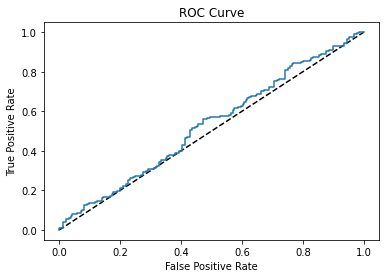

In [ ]:
# Generating the ROC curve
y_pred_proba_lstm_arima = model2.predict(x_test_arima)
fpr, tpr, thresholds = roc_curve(Y_test_arima, y_pred_proba_lstm_arima)
roc_auc = auc(fpr, tpr)
print("AUC score is " + str(roc_auc))

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# GRU - LSTM

In [ ]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import time

In [ ]:
FUTURE_PERIOD_PREDICT = 1
NAME = NAME = f"{seq_len}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=3, verbose=1)
checkpoint = ModelCheckpoint(NAME, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
# Model 3: LSTM - GRU 
model3 = Sequential()
model3.add(GRU(256, input_shape = (x_train_arima.shape[1],x_train_arima.shape[2]) , return_sequences=True))
model3.add(Dropout(0.4))
model3.add(LSTM(256))
model3.add(Dropout(0.4))
model3.add(Dense(64 ,  activation = 'relu'))
model3.add(Dense(2, activation='softmax'))
model3.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 180, 256)          208128    
_________________________________________________________________
dropout_14 (Dropout)         (None, 180, 256)          0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 130       
Total params: 750,018
Trainable params: 750,018
Non-trainable params: 0
_______________________________________________

In [ ]:
model3.compile(loss='sparse_categorical_crossentropy', optimizer='adam' , metrics = ['accuracy'])

In [ ]:
history3 = model3.fit(x_train_arima, y_train_arima, batch_size=32, epochs=25, callbacks = [checkpoint, lr_reduce])

Epoch 1/25
40/40 [==============================] - 49s 1s/step - loss: 0.7033 - accuracy: 0.5196
Epoch 2/25
40/40 [==============================] - 52s 1s/step - loss: 0.7120 - accuracy: 0.5452
Epoch 3/25
40/40 [==============================] - 50s 1s/step - loss: 0.6954 - accuracy: 0.5404
Epoch 4/25
40/40 [==============================] - 50s 1s/step - loss: 0.6970 - accuracy: 0.5276
Epoch 5/25
40/40 [==============================] - 50s 1s/step - loss: 0.6999 - accuracy: 0.5108
Epoch 6/25
40/40 [==============================] - 50s 1s/step - loss: 0.6989 - accuracy: 0.5284
Epoch 7/25
40/40 [==============================] - 49s 1s/step - loss: 0.6917 - accuracy: 0.5588
Epoch 8/25
40/40 [==============================] - 50s 1s/step - loss: 0.6906 - accuracy: 0.5524
Epoch 9/25
40/40 [==============================] - 50s 1s/step - loss: 0.6906 - accuracy: 0.5452
Epoch 10/25
40/40 [==============================] - 52s 1s/step - loss: 0.6888 - accuracy: 0.5396
Epoch 11/25
40/40 [

In [ ]:
scores3 = model3.evaluate(x_test_arima, y_test_arima, verbose=0)
print("Accuracy with GRU: %.2f%%" % (scores3[1]*100))

Accuracy with GRU: 40.74%


AUC score is 0.3497143817204301
roc auc is :0.3497143817204301


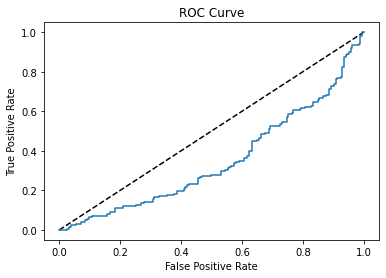

In [ ]:
# Generating the ROC curve
y_pred_proba_lstm_gru = model3.predict(x_test_arima)[:,1]
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba_lstm_gru)
roc_auc = auc(fpr, tpr)
print("AUC score is " + str(roc_auc))

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

The final attempt of stacked GRU with LSTM was not adopted in our framework since its performance fail to reach our expectation.